In [ ]:
!pip install gymnasium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 KB 21.0 MB/s eta 0:00:00


--------------------------------------------------------------------------------

Episode 1                           
Average Reward of last 100 18.0                           
Best Average Reward of last 100 18.0                           
Best Reward 18.0                           
Current Reward 18.0                           
Epsilon 0.9883201282955179

--------------------------------------------------------------------------------

Episode 2                           
Average Reward of last 100 18.0                           
Best Average Reward of last 100 18.0                           
Best Reward 18.0                           
Current Reward 18.0                           
Epsilon 0.9865445505639503

--------------------------------------------------------------------------------

Episode 3                           
Average Reward of last 100 17.666666666666668                           
Best Average Reward of last 100 18.0                           
Best Reward 18.0      

/var/folders/1j/s0fsj31s7v768nr7gw75qcyr0000gn/T/ipykernel_15389/2993708535.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  minibatch = np.array(self.memory.sample(batchSize))


--------------------------------------------------------------------------------

Episode 18                           
Average Reward of last 100 24.22222222222222                           
Best Average Reward of last 100 25.666666666666668                           
Best Reward 48.0                           
Current Reward 11.0                           
Epsilon 0.9479007959959663

--------------------------------------------------------------------------------

Episode 19                           
Average Reward of last 100 23.68421052631579                           
Best Average Reward of last 100 25.666666666666668                           
Best Reward 48.0                           
Current Reward 14.0                           
Epsilon 0.9465760624114542

--------------------------------------------------------------------------------

Episode 20                           
Average Reward of last 100 23.05                           
Best Average Reward of last 100 25.6666666

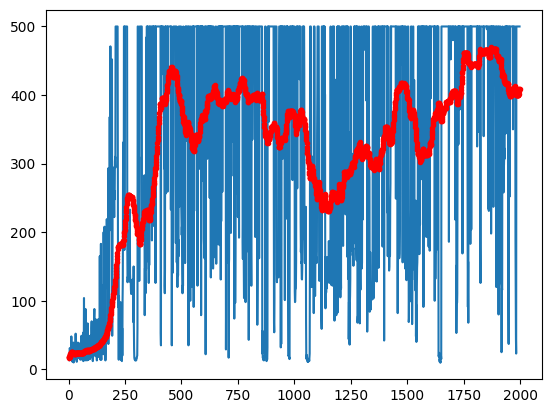

In [51]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque, namedtuple

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class NeuralNetwork(nn.Module):
    def __init__(self, env, learningRate):
        super().__init__()
        input_shape = env.observation_space.shape
        self.layer_1 = nn.Linear(*input_shape, 128)
        self.layer_2 = nn.Linear(128, 128)
        self.layer_3 = nn.Linear(128, env.action_space.n)
        self.optimizer = optim.Adam(self.parameters(), lr=learningRate)
        self.loss = nn.MSELoss()
        self.to(device)

    def forward(self, x):
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        return self.layer_3(x)


class ReplayMemory:
    def __init__(self, size):
        self.memory = deque([],maxlen=size)

    def add(self, transition):
        self.memory.append(transition)

    def sample(self, batchSize):
        return random.sample(self.memory,batchSize)

    def __len__(self):
        return len(self.memory)


class DQN:
    def __init__(self, env, hyperparams, nnModel):
        self.env = env
        self.epsilon = hyperparams.epsilon
        self.epsilonMax = self.epsilon
        self.epsilonMin = hyperparams.epsilonMin
        self.epsilonDecay = hyperparams.epsilonDecay
        self.discountFactor = hyperparams.discountFactor
        self.updateFrequency = hyperparams.targetNetworkUpdateFrequency
        self.batchSize = hyperparams.batchSize
        self.episodes = hyperparams.episodes
        self.action_space = env.action_space.n
        self.learningRate = hyperparams.learningRate
        self.observation_space = env.observation_space.shape[0]
        self.memory = ReplayMemory(hyperparams.memorySize)
        self.policyNetwork = NeuralNetwork(self.env, self.learningRate)
        self.targetNetwork = NeuralNetwork(self.env, self.learningRate)
        self.targetNetwork.load_state_dict(self.policyNetwork.state_dict())
        self.iterations = 0

    def getAction(self, state):
        if random.random() < self.epsilon:
            return self.env.action_space.sample()
        state = torch.tensor(state).float().detach()
        state = state.to(device)
        state = state.unsqueeze(0)
        qValues = self.policyNetwork(state)
        return torch.argmax(qValues).item()

    def optimize(self):
        batchSize = self.batchSize
        if len(self.memory) > batchSize:
            minibatch = np.array(self.memory.sample(batchSize))
            states = minibatch[:, 0].tolist()
            actions = minibatch[:, 1].tolist()
            rewards = minibatch[:, 2].tolist()
            nextStates = minibatch[:, 3].tolist()
            dones = minibatch[:, 4].tolist()

            states = torch.tensor(states, dtype=torch.float32).to(device)
            actions = torch.tensor(actions, dtype=torch.long).to(device)
            rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
            nextStates = torch.tensor(
                nextStates, dtype=torch.float32).to(device)
            dones = torch.tensor(dones, dtype=torch.bool).to(device)
            indices = np.arange(batchSize, dtype=np.int64)

            qValues = self.policyNetwork(states)
            qDotValues = None
            with torch.no_grad():
                qDotValues = self.targetNetwork(nextStates)

            predictedValues = qValues[indices, actions]
            predictedQDotValues = torch.max(qDotValues, dim=1)[0]

            targetValues = rewards + self.discountFactor * predictedQDotValues * dones

            loss = self.policyNetwork.loss(targetValues, predictedValues)
            self.policyNetwork.optimizer.zero_grad()
            loss.backward()
            self.policyNetwork.optimizer.step()

        

    def train(self):
        env = self.env
        observation_space = self.observation_space
        bestReward = 0
        bestAverageReward = 0
        rewards = []
        averageRewards = []
        for i in range(1, self.episodes):
            state,info = env.reset()
            state = np.reshape(state, [1, observation_space])
            totalRewardPerEpisode = 0
            steps = 0
            while True:
                action = self.getAction(state)
                nextState, reward, ter,trun, info = env.step(action)
                done = ter or trun
                nextState = np.reshape(nextState, [1, observation_space])
                self.memory.add((state[0], action, reward, nextState[0], 1 - done))
                self.optimize()
                state = nextState
                totalRewardPerEpisode += reward
                
                diff = self.epsilonMax - self.epsilonMin
                decayed_epsilon = self.epsilonMin + diff * \
                    np.exp((-1 * self.iterations) / self.epsilonDecay)
                self.iterations += 1
                self.epsilon = max(self.epsilonMin, decayed_epsilon)

                steps += 1
                if steps % 10 == 0:
                    self.targetNetwork.load_state_dict(
                        self.policyNetwork.state_dict())

                if done:
                    rewards.append(totalRewardPerEpisode)
                    if totalRewardPerEpisode > bestReward:
                        bestReward = totalRewardPerEpisode

                    averageReward = np.mean(np.array(rewards)[-100:])
                    if averageReward > bestAverageReward:
                        bestAverageReward = averageReward
                    print('-'*80)
                    print(
                        f"\nEpisode {i} \
                          \nAverage Reward of last 100 {averageReward} \
                          \nBest Average Reward of last 100 {bestAverageReward} \
                          \nBest Reward {bestReward} \
                          \nCurrent Reward {totalRewardPerEpisode} \
                          \nEpsilon {self.epsilon}\n"
                    )
                    averageRewards.append(averageReward)

                    break

                
        plt.plot(rewards)
        plt.plot(averageRewards,'r.')
#         plt.plot(averageRewards)
        plt.show()


Hyperparams = namedtuple('Hyperparams', (
    'epsilon',
    'epsilonMin',
    'epsilonDecay',
    'learningRate',
    'batchSize',
    'discountFactor',
    'targetNetworkUpdateFrequency',
    'episodes',
    'memorySize'
))

dqn = DQN(
    env=gym.make('CartPole-v1'),
    hyperparams=Hyperparams(
        epsilon=0.99,
        epsilonMin=0.001,
        epsilonDecay=10000,
        memorySize=10000,
        learningRate=1e-3,
        batchSize=128,
        discountFactor=0.99,
        targetNetworkUpdateFrequency=20,
        episodes=2000
    ),
    nnModel=NeuralNetwork
)

dqn.train()

In [23]:
!pip3 uninstall gym --yes
!pip3 install gym 


  Using cached gym-0.26.2-py3-none-any.whl


In [13]:
!brew install swig

Running `brew update --auto-update`...
==> Downloading https://formulae.brew.sh/api/formula.jws.json
######################################################################## 100.0%
==> Downloading https://formulae.brew.sh/api/cask.jws.json
######################################################################## 100.0%
==> Fetching swig
==> Downloading https://ghcr.io/v2/homebrew/core/swig/manifests/4.1.1
######################################################################## 100.0%
==> Downloading https://ghcr.io/v2/homebrew/core/swig/blobs/sha256:360d6e5438f0a
==> Downloading from https://pkg-containers.githubusercontent.com/ghcr1/blobs/sh
######################################################################## 100.0%
==> Pouring swig--4.1.1.arm64_ventura.bottle.tar.gz
🍺  /opt/homebrew/Cellar/swig/4.1.1: 775 files, 5.6MB
==> Running `brew cleanup swig`...
Disable this behaviour by setting HOMEBREW_NO_INSTALL_CLEANUP.
Hide these hints with HOMEBREW_NO_ENV_HINTS (see `man brew`).
==> `

In [15]:
!pip install gymnasium
!pip install gymnasium[box2d]

  Using cached gymnasium-0.28.1-py3-none-any.whl (925 kB)
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
  Using cached jax_jumpy-1.0.0-py3-none-any.whl (20 kB)
zsh:1: no matches found: gymnasium[box2d]


In [40]:

import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
# from google.colab import widgets
import time
import numpy as np

class GridEnvironment(gym.Env):
    metadata = { 'render.modes': [] }
    
    def __init__(self,env="Deterministic", max_timesteps=100):

        self.observation_space = spaces.Discrete(25)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = max_timesteps
        self.env = env
        self.timestep = 0
        self.agent_pos = [0, 0]
        self.goal_pos = [4, 4]
        self.reward1_pos = [1,4]
        self.reward2_pos = [2,3]
        self.reward3_pos = [3,1]
        self.reward4_pos = [1,1]
        self.state = np.zeros((5,5))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        self.state[tuple(self.reward1_pos)] = 0.1
        self.state[tuple(self.reward2_pos)] = 0.3
        self.state[tuple(self.reward3_pos)] = 0.8
        self.state[tuple(self.reward4_pos)] = 0.7

        
    def reset(self, **kwargs):
        self.agent_pos = [0, 0]
        self.state = np.zeros((5,5))
        self.goal_pos = [4, 4]
        self.reward1_pos = [1,4]
        self.reward2_pos = [2,3]
        self.reward3_pos = [3,1]
        self.reward4_pos = [1,1]
        self.timestep=0
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        self.state[tuple(self.reward1_pos)] = 0.1
        self.state[tuple(self.reward2_pos)] = 0.3
        self.state[tuple(self.reward3_pos)] = 0.8
        self.state[tuple(self.reward4_pos)] = 0.7
        observation = self.state.flatten()

        info = {}

        return observation
    
    def step(self, action):
        if self.env=="Stochastic":
          l=[0,1,2,3]
          action = np.random.choice([action] + list(filter(lambda a: a!=action, l)),p=[0.4,0.2,0.2,0.2])

        if action == 0:
          self.agent_pos[0] += 1
        if action == 1:
          self.agent_pos[0] -= 1
        if action == 2:
          self.agent_pos[1] += 1
        if action == 3:
          self.agent_pos[1] -= 1

        self.agent_pos = np.clip(self.agent_pos, 0, 4)

        self.state = np.zeros((5,5))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        self.state[tuple(self.reward1_pos)] = 0.1
        self.state[tuple(self.reward2_pos)] = 0.3
        self.state[tuple(self.reward3_pos)] = 0.8
        self.state[tuple(self.reward4_pos)] = 0.7
        
        reward = 0
        if np.array_equal(self.agent_pos, self.goal_pos):
          self.state[tuple(self.goal_pos)] = 1
          reward = 4
        
        if np.array_equal(self.agent_pos, self.reward1_pos):
          self.state[tuple(self.reward1_pos)] = 1
          reward = -2


        if np.array_equal(self.agent_pos, self.reward2_pos):
          self.state[tuple(self.reward2_pos)] = 1
          reward = -3


        if np.array_equal(self.agent_pos, self.reward3_pos):
          self.state[tuple(self.reward3_pos)] = 1
          reward = -1


        if np.array_equal(self.agent_pos, self.reward4_pos):
          self.state[tuple(self.reward4_pos)] = 1
          reward = -2.5
        
        observation = self.state.flatten()


        
        self.timestep += 1

        terminated = True if self.timestep >= self.max_timesteps or np.array_equal(self.agent_pos,self.goal_pos) else False
        truncated = True if np.all((self.agent_pos >=0 ) & (self.agent_pos <= 11)) else False

        info = {}

        
        return observation, reward, truncated, terminated, info
        
    def render(self):
        plt.imshow(self.state)


--------------------------------------------------------------------------------

Episode 1                           
Average Reward of last 100 -1.5                           
Best Average Reward of last 100 0                           
Best Reward 0                           
Current Reward -1.5                           
Epsilon 0.8979346760330256

--------------------------------------------------------------------------------

Episode 2                           
Average Reward of last 100 -9.5                           
Best Average Reward of last 100 0                           
Best Reward 0                           
Current Reward -17.5                           
Epsilon 0.8938182515581917

--------------------------------------------------------------------------------

Episode 3                           
Average Reward of last 100 -11.0                           
Best Average Reward of last 100 0                           
Best Reward 0                           
Current 

/var/folders/1j/s0fsj31s7v768nr7gw75qcyr0000gn/T/ipykernel_15389/1615032658.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  minibatch = np.array(self.memory.sample(batchSize))


--------------------------------------------------------------------------------

Episode 7                           
Average Reward of last 100 -15.142857142857142                           
Best Average Reward of last 100 0                           
Best Reward 0                           
Current Reward -14.5                           
Epsilon 0.8655274304567568

--------------------------------------------------------------------------------

Episode 8                           
Average Reward of last 100 -15.375                           
Best Average Reward of last 100 0                           
Best Reward 0                           
Current Reward -17.0                           
Epsilon 0.8569252387953075

--------------------------------------------------------------------------------

Episode 9                           
Average Reward of last 100 -16.666666666666668                           
Best Average Reward of last 100 0                           
Best Reward 0   

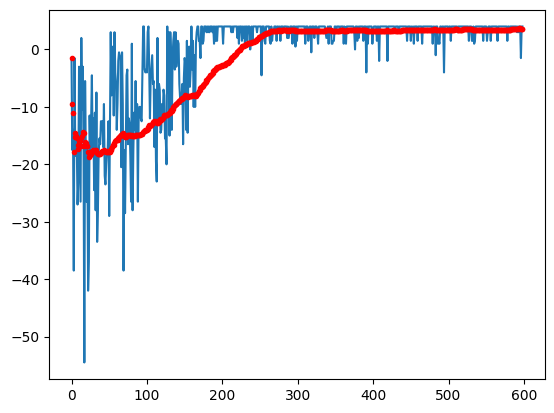

In [58]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque, namedtuple

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class NeuralNetwork(nn.Module):
    def __init__(self, env, learningRate):
        super().__init__()
        input_shape = env.observation_space.n
        self.layer_1 = nn.Linear(input_shape, 128)
        self.layer_2 = nn.Linear(128, 128)
        self.layer_3 = nn.Linear(128, env.action_space.n)
        self.optimizer = optim.Adam(self.parameters(), lr=learningRate)
        self.loss = nn.MSELoss()
        self.to(device)

    def forward(self, x):
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        return self.layer_3(x)


class ReplayMemory:
    def __init__(self, size):
        self.memory = deque([],maxlen=size)

    def add(self, transition):
        self.memory.append(transition)

    def sample(self, batchSize):
        return random.sample(self.memory,batchSize)

    def __len__(self):
        return len(self.memory)


class DQN:
    def __init__(self, env, hyperparams, nnModel):
        self.env = env
        self.epsilon = hyperparams.epsilon
        self.epsilonMax = self.epsilon
        self.epsilonMin = hyperparams.epsilonMin
        self.epsilonDecay = hyperparams.epsilonDecay
        self.discountFactor = hyperparams.discountFactor
        self.updateFrequency = hyperparams.targetNetworkUpdateFrequency
        self.batchSize = hyperparams.batchSize
        self.episodes = hyperparams.episodes
        self.action_space = env.action_space.n
        self.learningRate = hyperparams.learningRate
        self.observation_space = env.observation_space.n
        self.memory = ReplayMemory(hyperparams.memorySize)
        self.policyNetwork = NeuralNetwork(self.env, self.learningRate)
        self.targetNetwork = NeuralNetwork(self.env, self.learningRate)
        self.targetNetwork.load_state_dict(self.policyNetwork.state_dict())
        self.iterations = 0

    def getAction(self, state):
        if random.random() < self.epsilon:
            return self.env.action_space.sample()
        state = torch.tensor(state).float().detach()
        state = state.to(device)
        state = state.unsqueeze(0)
        qValues = self.policyNetwork(state)
        return torch.argmax(qValues).item()

    def optimize(self):
        batchSize = self.batchSize
        if len(self.memory) > batchSize:
            minibatch = np.array(self.memory.sample(batchSize))
            states = minibatch[:, 0].tolist()
            actions = minibatch[:, 1].tolist()
            rewards = minibatch[:, 2].tolist()
            nextStates = minibatch[:, 3].tolist()
            dones = minibatch[:, 4].tolist()

            states = torch.tensor(states, dtype=torch.float32).to(device)
            actions = torch.tensor(actions, dtype=torch.long).to(device)
            rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
            nextStates = torch.tensor(
                nextStates, dtype=torch.float32).to(device)
            dones = torch.tensor(dones, dtype=torch.bool).to(device)
            indices = np.arange(batchSize, dtype=np.int64)

            qValues = self.policyNetwork(states)
            qDotValues = None
            with torch.no_grad():
                qDotValues = self.targetNetwork(nextStates)

            predictedValues = qValues[indices, actions]
            predictedQDotValues = torch.max(qDotValues, dim=1)[0]

            targetValues = rewards + self.discountFactor * predictedQDotValues * dones

            loss = self.policyNetwork.loss(targetValues, predictedValues)
            self.policyNetwork.optimizer.zero_grad()
            loss.backward()
            self.policyNetwork.optimizer.step()

        

    def train(self):
        env = self.env
        observation_space = self.observation_space
        bestReward = 0
        bestAverageReward = 0
        rewards = []
        averageRewards = []
        for i in range(1, self.episodes):
            state = env.reset()
            state = np.reshape(state, [1, observation_space])
            totalRewardPerEpisode = 0
            steps = 0
            while True:
                action = self.getAction(state)
                nextState, reward, _, ter, info = env.step(action)
                done = ter 
                nextState = np.reshape(nextState, [1, observation_space])
                self.memory.add((state[0], action, reward, nextState[0], 1 - done))
                self.optimize()
                state = nextState
                totalRewardPerEpisode += reward
                
                diff = self.epsilonMax - self.epsilonMin
                decayed_epsilon = self.epsilonMin + diff * \
                    np.exp((-1 * self.iterations) / self.epsilonDecay)
                self.iterations += 1
                self.epsilon = max(self.epsilonMin, decayed_epsilon)

                steps += 1
                if steps % 10 == 0:
                    self.targetNetwork.load_state_dict(
                        self.policyNetwork.state_dict())

                if done:
                    rewards.append(totalRewardPerEpisode)
                    if totalRewardPerEpisode > bestReward:
                        bestReward = totalRewardPerEpisode

                    averageReward = np.mean(np.array(rewards)[-100:])
                    if averageReward > bestAverageReward:
                        bestAverageReward = averageReward
                    print('-'*80)
                    print(
                        f"\nEpisode {i} \
                          \nAverage Reward of last 100 {averageReward} \
                          \nBest Average Reward of last 100 {bestAverageReward} \
                          \nBest Reward {bestReward} \
                          \nCurrent Reward {totalRewardPerEpisode} \
                          \nEpsilon {self.epsilon}\n"
                    )
                    averageRewards.append(averageReward)

                    break

                
        plt.plot(rewards)
        plt.plot(averageRewards,'r.')
        plt.show()


Hyperparams = namedtuple('Hyperparams', (
    'epsilon',
    'epsilonMin',
    'epsilonDecay',
    'learningRate',
    'batchSize',
    'discountFactor',
    'targetNetworkUpdateFrequency',
    'episodes',
    'memorySize'
))

dqn = DQN(
    env=GridEnvironment(env="Deterministic", max_timesteps=100),
    hyperparams=Hyperparams(
        epsilon=0.9,
        epsilonMin=0.001,
        epsilonDecay=10000,
        memorySize=1000,
        learningRate=0.001,
        batchSize=64,
        discountFactor=0.99,
        targetNetworkUpdateFrequency=20,
        episodes=600
    ),
    nnModel=NeuralNetwork
)

dqn.train()

--------------------------------------------------------------------------------

Episode 1                           
Average Reward of last 100 31.0                           
Best Average Reward of last 100 31.0                           
Best Reward 31.0                           
Current Reward 31.0                           
Epsilon 0.9870344805033843

--------------------------------------------------------------------------------

Episode 2                           
Average Reward of last 100 22.0                           
Best Average Reward of last 100 31.0                           
Best Reward 31.0                           
Current Reward 13.0                           
Epsilon 0.9857521823531178

--------------------------------------------------------------------------------

Episode 3                           
Average Reward of last 100 19.666666666666668                           
Best Average Reward of last 100 31.0                           
Best Reward 31.0      

/var/folders/1j/s0fsj31s7v768nr7gw75qcyr0000gn/T/ipykernel_15389/5547893.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  minibatch = np.array(self.memory.sample(batchSize))


--------------------------------------------------------------------------------

Episode 23                           
Average Reward of last 100 19.0                           
Best Average Reward of last 100 31.0                           
Best Reward 37.0                           
Current Reward 23.0                           
Epsilon 0.9477638740981792

--------------------------------------------------------------------------------

Episode 24                           
Average Reward of last 100 18.75                           
Best Average Reward of last 100 31.0                           
Best Reward 37.0                           
Current Reward 13.0                           
Epsilon 0.946532594566952

--------------------------------------------------------------------------------

Episode 25                           
Average Reward of last 100 18.72                           
Best Average Reward of last 100 31.0                           
Best Reward 37.0                

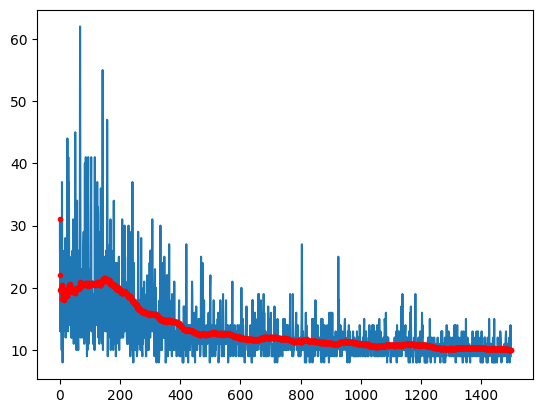

In [67]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque, namedtuple

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DuelingNetwork(nn.Module):
    def __init__(self, env, learningRate):
        super().__init__()
        input_shape = env.observation_space.shape
        self.layer_1 = nn.Linear(*input_shape, 128)
        self.layer_2 = nn.Linear(128, 64)
        self.layer_3 = nn.Linear(64, env.action_space.n)
        self.layer_4 = nn.Linear(64, 1)
        self.optimizer = optim.Adam(self.parameters(), lr=learningRate)
        self.loss = nn.MSELoss()
        self.to(device)

    def forward(self, x):
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        advantage = self.layer_3(x)
        value = self.layer_4(x)
        q = value + (advantage - torch.mean(advantage, dim=1, keepdim=True))
        return q


class ReplayMemory:
    def __init__(self, size):
        self.memory = deque([],maxlen=size)

    def add(self, transition):
        self.memory.append(transition)

    def sample(self, batchSize):
        return random.sample(self.memory,batchSize)

    def __len__(self):
        return len(self.memory)


class DuelingDQN:
    def __init__(self, env, hyperparams, nnModel):
        self.env = env
        self.epsilon = hyperparams.epsilon
        self.epsilonMax = self.epsilon
        self.epsilonMin = hyperparams.epsilonMin
        self.epsilonDecay = hyperparams.epsilonDecay
        self.discountFactor = hyperparams.discountFactor
        self.updateFrequency = hyperparams.targetNetworkUpdateFrequency
        self.batchSize = hyperparams.batchSize
        self.episodes = hyperparams.episodes
        self.action_space = env.action_space.n
        self.learningRate = hyperparams.learningRate
        self.observation_space = env.observation_space.shape[0]
        self.memory = ReplayMemory(hyperparams.memorySize)
        self.policyNetwork = nnModel(self.env, self.learningRate)
        self.targetNetwork = nnModel(self.env, self.learningRate)
        self.targetNetwork.load_state_dict(self.policyNetwork.state_dict())
        self.iterations = 0

    def getAction(self, state):
        if random.random() < self.epsilon:
            return self.env.action_space.sample()
        state = torch.tensor(state).float().detach()
        state = state.to(device)
        state = state.unsqueeze(0)
        qValues = self.policyNetwork(state)
        return torch.argmax(qValues).item()

    def optimize(self):
        batchSize = self.batchSize
        if len(self.memory) > batchSize:
            minibatch = np.array(self.memory.sample(batchSize))
            states = minibatch[:, 0].tolist()
            actions = minibatch[:, 1].tolist()
            rewards = minibatch[:, 2].tolist()
            nextStates = minibatch[:, 3].tolist()
            dones = minibatch[:, 4].tolist()

            states = torch.tensor(states, dtype=torch.float32).to(device)
            actions = torch.tensor(actions, dtype=torch.long).to(device)
            rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
            nextStates = torch.tensor(
                nextStates, dtype=torch.float32).to(device)
            dones = torch.tensor(dones, dtype=torch.bool).to(device)
            indices = np.arange(batchSize, dtype=np.int64)

            qValues = self.policyNetwork(states)
            qDotValues = None
            with torch.no_grad():
                qDotValues = self.targetNetwork(nextStates)

            predictedValues = qValues[indices, actions]
            predictedQDotValues = torch.max(qDotValues, dim=1)[0]

            targetValues = rewards + self.discountFactor * predictedQDotValues * dones

            loss = self.policyNetwork.loss(targetValues, predictedValues)
#             self.policyNetwork.optimizer.zero_grad()
            loss.backward()
            self.policyNetwork.optimizer.step()

        

    def train(self):
        env = self.env
        observation_space = self.observation_space
        bestReward = 0
        bestAverageReward = 0
        rewards = []
        averageRewards = []
        for i in range(1, self.episodes):
            state,info = env.reset()
            state = np.reshape(state, [1, observation_space])
            totalRewardPerEpisode = 0
            steps = 0
            while True:
                action = self.getAction(state)
                nextState, reward, ter,trun, info = env.step(action)
                done = ter or trun
                nextState = np.reshape(nextState, [1, observation_space])
                self.memory.add((state[0], action, reward, nextState[0], 1 - done))
                self.optimize()
                state = nextState
                totalRewardPerEpisode += reward
                
                diff = self.epsilonMax - self.epsilonMin
                decayed_epsilon = self.epsilonMin + diff * \
                    np.exp((-1 * self.iterations) / self.epsilonDecay)
                self.iterations += 1
                self.epsilon = max(self.epsilonMin, decayed_epsilon)

                steps += 1
                if steps % 10 == 0:
                    self.targetNetwork.load_state_dict(
                        self.policyNetwork.state_dict())

                if done:
                    rewards.append(totalRewardPerEpisode)
                    if totalRewardPerEpisode > bestReward:
                        bestReward = totalRewardPerEpisode

                    averageReward = np.mean(np.array(rewards)[-100:])
                    if averageReward > bestAverageReward:
                        bestAverageReward = averageReward
                    print('-'*80)
                    print(
                        f"\nEpisode {i} \
                          \nAverage Reward of last 100 {averageReward} \
                          \nBest Average Reward of last 100 {bestAverageReward} \
                          \nBest Reward {bestReward} \
                          \nCurrent Reward {totalRewardPerEpisode} \
                          \nEpsilon {self.epsilon}\n"
                    )
                    averageRewards.append(averageReward)

                    break

                
        plt.plot(rewards)
        plt.plot(averageRewards,'r.')
#         plt.plot(averageRewards)
        plt.show()


Hyperparams = namedtuple('Hyperparams', (
    'epsilon',
    'epsilonMin',
    'epsilonDecay',
    'learningRate',
    'batchSize',
    'discountFactor',
    'targetNetworkUpdateFrequency',
    'episodes',
    'memorySize'
))

dqn = DuelingDQN(
    env=gym.make('CartPole-v1'),
    hyperparams=Hyperparams(
        epsilon=0.99,
        epsilonMin=0.00001,
        epsilonDecay=10000,
        memorySize=10000,
        learningRate=0.001,
        batchSize=128,
        discountFactor=0.994,
        targetNetworkUpdateFrequency=20,
        episodes=1500
    ),
    nnModel=DuelingNetwork
)

dqn.train()

In [68]:
torch.cuda.is_available()

False

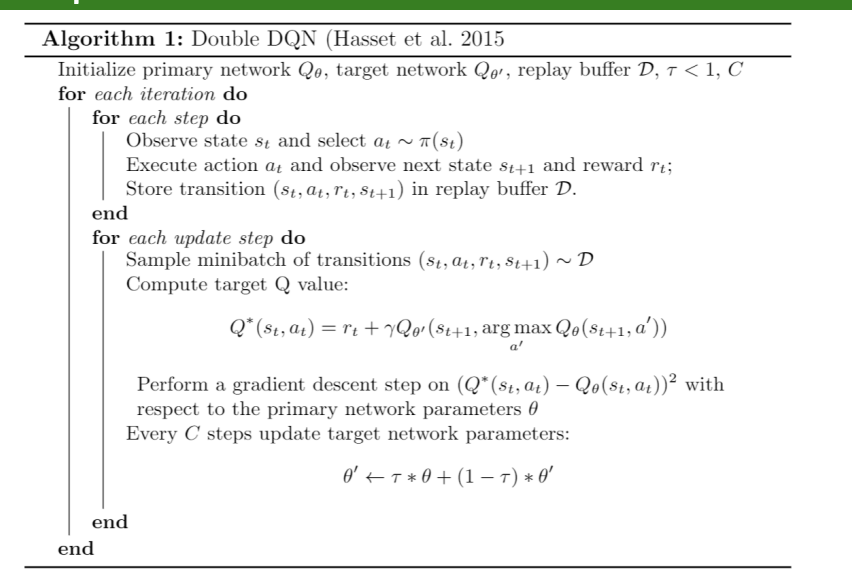

--------------------------------------------------------------------------------

Episode 1                           
Average Reward of last 100 23.0                           
Best Average Reward of last 100 23.0                           
Best Reward 23.0                           
Current Reward 23.0                           
Epsilon 0.9878265916258195

--------------------------------------------------------------------------------

Episode 2                           
Average Reward of last 100 19.0                           
Best Average Reward of last 100 23.0                           
Best Reward 23.0                           
Current Reward 15.0                           
Epsilon 0.9863474613634146

--------------------------------------------------------------------------------

Episode 3                           
Average Reward of last 100 16.0                           
Best Average Reward of last 100 23.0                           
Best Reward 23.0                    

/var/folders/1j/s0fsj31s7v768nr7gw75qcyr0000gn/T/ipykernel_15389/210253072.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  minibatch = np.array(self.memory.sample(batchSize))


--------------------------------------------------------------------------------

Episode 19                           
Average Reward of last 100 23.68421052631579                           
Best Average Reward of last 100 25.2                           
Best Reward 62.0                           
Current Reward 22.0                           
Epsilon 0.9465760624114542

--------------------------------------------------------------------------------

Episode 20                           
Average Reward of last 100 25.05                           
Best Average Reward of last 100 25.2                           
Best Reward 62.0                           
Current Reward 51.0                           
Epsilon 0.9417659008312061

--------------------------------------------------------------------------------

Episode 21                           
Average Reward of last 100 24.571428571428573                           
Best Average Reward of last 100 25.2                           
Best 

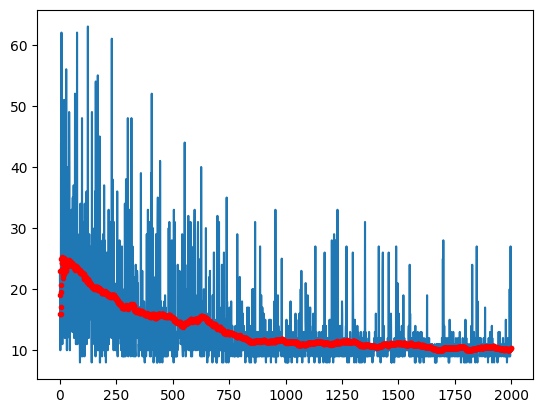

In [89]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque, namedtuple

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class NeuralNetwork(nn.Module):
    def __init__(self, env, learningRate):
        super().__init__()
        input_shape = env.observation_space.shape
        self.layer_1 = nn.Linear(*input_shape, 128)
        self.layer_2 = nn.Linear(128, 128)
        self.layer_3 = nn.Linear(128, env.action_space.n)
        self.optimizer = optim.Adam(self.parameters(), lr=learningRate)
        self.loss = nn.MSELoss()
        self.to(device)

    def forward(self, x):
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        return self.layer_3(x)


class ReplayMemory:
    def __init__(self, size):
        self.memory = deque([],maxlen=size)

    def add(self, transition):
        self.memory.append(transition)

    def sample(self, batchSize):
        return random.sample(self.memory,batchSize)

    def __len__(self):
        return len(self.memory)


class DoubleDQN:
    def __init__(self, env, hyperparams, nnModel):
        self.env = env
        self.epsilon = hyperparams.epsilon
        self.epsilonMax = self.epsilon
        self.epsilonMin = hyperparams.epsilonMin
        self.epsilonDecay = hyperparams.epsilonDecay
        self.discountFactor = hyperparams.discountFactor
        self.updateFrequency = hyperparams.targetNetworkUpdateFrequency
        self.batchSize = hyperparams.batchSize
        self.episodes = hyperparams.episodes
        self.action_space = env.action_space.n
        self.learningRate = hyperparams.learningRate
        self.observation_space = env.observation_space.shape[0]
        self.memory = ReplayMemory(hyperparams.memorySize)
        self.policyNetwork = NeuralNetwork(self.env, self.learningRate)
        self.targetNetwork = NeuralNetwork(self.env, self.learningRate)
        self.targetNetwork.load_state_dict(self.policyNetwork.state_dict())
        self.iterations = 0

    def getAction(self, state):
        if random.random() < self.epsilon:
            return self.env.action_space.sample()
        state = torch.tensor(state).float().detach()
        state = state.to(device)
        state = state.unsqueeze(0)
        qValues = self.policyNetwork(state)
        return torch.argmax(qValues).item()

    def optimize(self):
        batchSize = self.batchSize
        if len(self.memory) > batchSize:
            minibatch = np.array(self.memory.sample(batchSize))
            states = minibatch[:, 0].tolist()
            actions = minibatch[:, 1].tolist()
            rewards = minibatch[:, 2].tolist()
            nextStates = minibatch[:, 3].tolist()
            dones = minibatch[:, 4].tolist()

            states = torch.tensor(states, dtype=torch.float32).to(device)
            actions = torch.tensor(actions, dtype=torch.long).to(device)
            rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
            nextStates = torch.tensor(
                nextStates, dtype=torch.float32).to(device)
            dones = torch.tensor(dones, dtype=torch.bool).to(device)
            indices = np.arange(batchSize, dtype=np.int64)

            qValues = self.policyNetwork(states)
            qDotValues = None
            with torch.no_grad():
                qDotValues = self.targetNetwork(nextStates)
            
            z = torch.argmax(qDotValues,dim=1)
            normalValue = qValues[indices, actions]
            predictedValues = qValues[indices, z]
#             predictedQDotValues = torch.max(qDotValues, dim=1)[0]
            
            targetValues = rewards + self.discountFactor * predictedValues 
#             print(targetValues.size(),normalValue.size())


            loss = self.policyNetwork.loss(targetValues, normalValue)
            self.policyNetwork.optimizer.zero_grad()
            loss.backward()
            self.policyNetwork.optimizer.step()

        

    def train(self):
        env = self.env
        observation_space = self.observation_space
        bestReward = 0
        bestAverageReward = 0
        rewards = []
        averageRewards = []
        for i in range(1, self.episodes):
            state,info = env.reset()
            state = np.reshape(state, [1, observation_space])
            totalRewardPerEpisode = 0
            steps = 0
            while True:
                action = self.getAction(state)
                nextState, reward, ter,trun, info = env.step(action)
                done = ter or trun
                nextState = np.reshape(nextState, [1, observation_space])
                self.memory.add((state[0], action, reward, nextState[0], 1 - done))
                self.optimize()
                state = nextState
                totalRewardPerEpisode += reward
                
                diff = self.epsilonMax - self.epsilonMin
                decayed_epsilon = self.epsilonMin + diff * \
                    np.exp((-1 * self.iterations) / self.epsilonDecay)
                self.iterations += 1
                self.epsilon = max(self.epsilonMin, decayed_epsilon)

                steps += 1
                if steps % 10 == 0:
                    self.targetNetwork.load_state_dict(
                        self.policyNetwork.state_dict())

                if done:
                    rewards.append(totalRewardPerEpisode)
                    if totalRewardPerEpisode > bestReward:
                        bestReward = totalRewardPerEpisode

                    averageReward = np.mean(np.array(rewards)[-100:])
                    if averageReward > bestAverageReward:
                        bestAverageReward = averageReward
                    print('-'*80)
                    print(
                        f"\nEpisode {i} \
                          \nAverage Reward of last 100 {averageReward} \
                          \nBest Average Reward of last 100 {bestAverageReward} \
                          \nBest Reward {bestReward} \
                          \nCurrent Reward {totalRewardPerEpisode} \
                          \nEpsilon {self.epsilon}\n"
                    )
                    averageRewards.append(averageReward)

                    break

                
        plt.plot(rewards)
        plt.plot(averageRewards,'r.')
#         plt.plot(averageRewards)
        plt.show()


Hyperparams = namedtuple('Hyperparams', (
    'epsilon',
    'epsilonMin',
    'epsilonDecay',
    'learningRate',
    'batchSize',
    'discountFactor',
    'targetNetworkUpdateFrequency',
    'episodes',
    'memorySize'
))

dqn = DoubleDQN(
    env=gym.make('CartPole-v1'),
    hyperparams=Hyperparams(
        epsilon=0.99,
        epsilonMin=0.001,
        epsilonDecay=10000,
        memorySize=10000,
        learningRate=1e-3,
        batchSize=128,
        discountFactor=0.99,
        targetNetworkUpdateFrequency=20,
        episodes=2000
    ),
    nnModel=NeuralNetwork
)

dqn.train()

In [69]:
a = torch.randn(4, 4)
a
torch.argmax(a)

tensor(13)

In [70]:
a

tensor([[ 0.2876,  1.1602, -0.0651,  1.1844],
        [ 1.1703,  1.6608,  0.2707, -0.0102],
        [ 0.0073,  0.8234,  0.6779,  1.7561],
        [ 0.0966,  2.0785, -0.1148, -0.2750]])

In [72]:

z = torch.argmax(a,dim=1)

In [75]:
z

tensor([3, 1, 3, 1])

In [79]:
indices = np.arange(4, dtype=np.int64)


In [80]:
indices

array([0, 1, 2, 3])

In [82]:
a[indices,z]

tensor([1.1844, 1.6608, 1.7561, 2.0785])